In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from pathlib import Path
from omegaconf import OmegaConf
from plaid.datasets import NUM_ORGANISM_CLASSES, NUM_FUNCTION_CLASSES
import hydra
from plaid.pipeline import SampleLatent
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda")

/homefs/home/lux70/code/plaid/src/plaid/denoisers/modules/_attention.py:12: FutureWarning: xformers.components is deprecated and is not maintained anymore. It might be removed in a future version of xFormers 
  from xformers.components.attention import ScaledDotProduct


In [3]:
with open("/homefs/home/lux70/code/plaid/best_idxs.txt", "r") as f:
    lines = f.readlines()
lines = [int(x.rstrip("\n")) for x in lines]
lines

[547, 192, 169, 29, 38, 229, 86, 1907, 162, 1790, 1386, 1854, 641, 827, 1907]

In [4]:
go_idx_df = pd.read_csv("/data/lux70/data/pfam/go_index.csv")
go_idx_df

,Unnamed: 0,GO_term,pfam_id,GO_id,GO_level,count,GO_idx
0,161,G protein-coupled receptor activity,PF00001,GO:0004930,function,11,0
1,54,ATP hydrolysis activity,PF00004,GO:0016887,function,15,1
2,52,ATP binding,PF00006,GO:0005524,function,178,2
3,174,GTPase activity,PF00009,GO:0003924,function,10,3
4,1634,protein dimerization activity,PF00010,GO:0046983,function,22,4
...,...,...,...,...,...,...,...
2214,249,RNA cap binding,PF21071,GO:0000339,function,1,2214
2215,730,deoxyribonuclease I activity,PF21111,GO:0004530,function,1,2215
2216,1599,potassium channel regulator activity,PF21201,GO:0015459,function,1,2216
2217,1180,microtubule,PF21410,GO:0005874,component,3,2217


In [5]:
import numpy as np
np.unique(go_idx_df.GO_level, return_counts=True)

(array(['component', 'function', 'process'], dtype=object),
 array([324, 945, 950]))

In [6]:
for idx in lines:
    tmp = go_idx_df[go_idx_df.GO_idx == idx]
    print(idx, tmp.GO_term.values[0], tmp.GO_id.values[0], "\t", tmp.GO_level.values[0])

547 metal ion transmembrane transporter activity GO:0046873 	 function
192 protein deubiquitination GO:0016579 	 process
169 kinase activity GO:0016301 	 function
29 phosphorelay signal transduction system GO:0000160 	 process
38 metal ion binding GO:0046872 	 function
229 zinc ion binding GO:0008270 	 function
86 regulation of DNA-templated transcription GO:0006355 	 process
1907 positive regulation of cyclin-dependent protein serine/threonine kinase activity GO:0045737 	 process
162 DNA-templated transcription initiation GO:0006352 	 process
1790 nuclear-transcribed mRNA catabolic process, nonsense-mediated decay GO:0000184 	 process
1386 oxidoreductase activity, acting on NAD(P)H, quinone or similar compound as acceptor GO:0016655 	 function
1854 telomere maintenance via telomerase GO:0007004 	 process
641 lysyl-tRNA aminoacylation GO:0006430 	 process
827 glucuronate isomerase activity GO:0008880 	 function
1907 positive regulation of cyclin-dependent protein serine/threonine kinas

In [7]:
import pandas as pd

pfam2go = pd.read_csv("/data/lux70/data/pfam/pfam2go.csv")
pfam2go.head()

,pfam_id,GO_id,GO_term,GO_level,count,GO_idx
0,PF00001,GO:0004930,G protein-coupled receptor activity,function,11,0
1,PF00002,GO:0004930,G protein-coupled receptor activity,function,11,0
2,PF00003,GO:0004930,G protein-coupled receptor activity,function,11,0
3,PF00004,GO:0016887,ATP hydrolysis activity,function,15,1
4,PF00005,GO:0016887,ATP hydrolysis activity,function,15,1


In [77]:
tmp = pfam2go[pfam2go['GO_level'] == "component"]
tmp = tmp.groupby("GO_term").first()
tmp = tmp.sort_values(by='count',ascending=False)
tmp.head(n=30)

,pfam_id,GO_id,GO_level,count,GO_idx
GO_term,,,,,
membrane,PF00146,GO:0016020,component,541,64
extracellular region,PF00039,GO:0005576,component,203,16
nucleus,PF01125,GO:0005634,component,149,411
cytoplasm,PF01021,GO:0005737,component,103,370
ribosome,PF00164,GO:0005840,component,86,74
viral capsid,PF00286,GO:0019028,component,65,138
plasma membrane,PF02608,GO:0005886,component,39,823
viral envelope,PF00516,GO:0019031,component,33,212
mitochondrion,PF05676,GO:0005739,component,27,1358


# Examine specific GO terms:

In [ ]:
# read in the full validation dataset

import pandas as pd
df = pd.read_parquet("/data/lux70/data/pfam/val.parquet")# df = pd.read_parquet("/data/lux70/data/pfam/val_shard_info.parquet")

In [83]:
function_idx = 38
tmp = pfam2go[pfam2go.GO_idx == function_idx]
go_id = tmp.GO_id.values[0]
go_term = tmp.GO_term.values[0]
print(go_id, go_term)
tmp

GO:0046872 metal ion binding


,pfam_id,GO_id,GO_term,GO_level,count,GO_idx
53,PF00097,GO:0046872,metal ion binding,function,48,38
75,PF00131,GO:0046872,metal ion binding,function,48,38
265,PF00403,GO:0046872,metal ion binding,function,48,38
301,PF00465,GO:0046872,metal ion binding,function,48,38
320,PF00491,GO:0046872,metal ion binding,function,48,38
422,PF00642,GO:0046872,metal ion binding,function,48,38
918,PF01363,GO:0046872,metal ion binding,function,48,38
977,PF01439,GO:0046872,metal ion binding,function,48,38
1116,PF01676,GO:0046872,metal ion binding,function,48,38
1186,PF01799,GO:0046872,metal ion binding,function,48,38


In [84]:
tmp = df[df.GO_id == go_id]
print(tmp.pfam_id.unique())
tmp.head()

['PF16785' 'PF14928' 'PF02583' 'PF00097' 'PF00642' 'PF13008' 'PF04704']


,pfam_id,organism,sequence,GO_id,GO_term,GO_level,GO_counts,GO_idx,organism_index,organism_counts,seq_len
662796,PF16785,9BACT,SKISRGVLMLGALGMLVSVPVLNAQPSPAGNVLDSIAHAKEAVEHG...,GO:0046872,metal ion binding,function,48.0,38,30,3061628,110
662797,PF16785,9PROT,MKTITLLTTLIMMTFFSLSAVAGASHLDQAIQHSEAAAKSADGKDV...,GO:0046872,metal ion binding,function,48.0,38,40,1199947,109
662798,PF16785,NITEU,KKILSILSSTFILSLFMLSSVNAQVEDVHLQEAIRQTEAVVLAVDV...,GO:0046872,metal ion binding,function,48.0,38,1065,2987,109
662799,PF16785,9PROT,MRIISTMIVTGALACFMSTPVLASDAGHTSEAMEHAGKAQAHGEMG...,GO:0046872,metal ion binding,function,48.0,38,40,1199947,112
662800,PF16785,9GAMM,TMKIAALCLGISLAGAPFATYAAESHIAEAIKHAEAAAKATDGKTI...,GO:0046872,metal ion binding,function,48.0,38,4,2601336,100


In [85]:
from plaid.utils import round_to_multiple
effL = [round_to_multiple(x / 2, 4) for x in L]
print(np.unique(effL, return_counts=True))

(array([ 24,  28,  32,  36,  40,  44,  52,  56,  60,  64,  68,  72,  76,
        80,  84,  88,  92,  96, 100, 104]), array([2, 3, 2, 2, 1, 2, 1, 2, 3, 1, 1, 3, 4, 4, 7, 3, 3, 8, 5, 3]))


In [86]:
plt.rcParams['figure.figsize'] = (4,3)
plt.rcParams['figure.dpi'] = 200

Text(0.5, 1.0, 'metal ion binding')

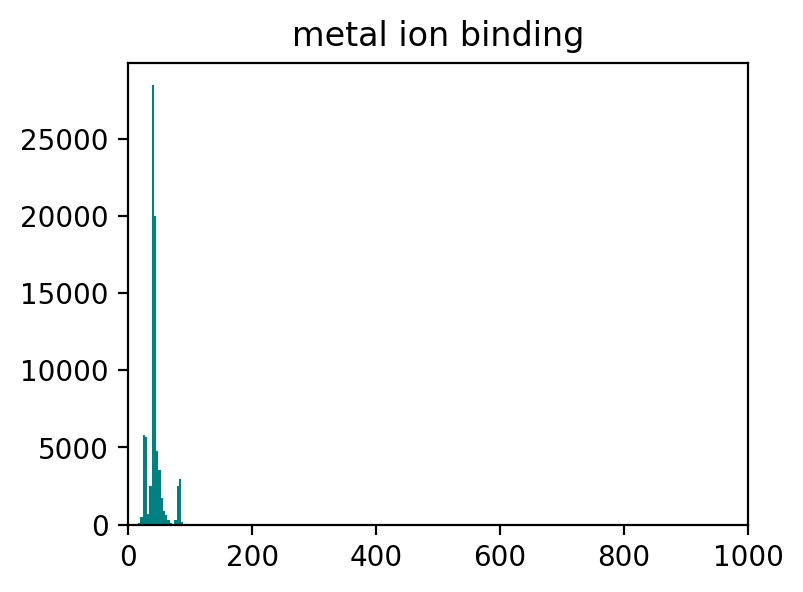

In [87]:
_ = plt.hist(tmp.seq_len, bins=100, color='teal')
plt.xlim(0, 1000)
plt.title(go_term)